In [15]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

# Описание эксперимента
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрэпом и u-тестом

# Загрузим данные

## Описание колонок
* **value** – значения метрики
* **experimentVariant** – Вариант теста (*Control* – контроль, *Treatment* – тест)

In [16]:
df = pd.read_csv('hw_bootstrap.csv', sep=';', index_col=0)

## Посмотрим на данные и типы данных

In [17]:
print(f'''
количество строк: {df.shape[0]}
количество колонок: {df.shape[1]}
количество пропущенных значений: {df.isna().sum().sum()}
''')


количество строк: 1000
количество колонок: 2
количество пропущенных значений: 0



In [18]:
df.head()

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control


In [19]:
df.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

In [20]:
df.dtypes

value                object
experimentVariant    object
dtype: object

In [37]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

Из-за разделителя запятой **value** имеет строковый тип данных

## Предобработаем данные
**value** нужно сделать числовым, для этого:
* воспользуемся функцией **str.replase** и заменим *запятую* на *точку*
* далее приведем к типу **float**

In [21]:

df.value = df.value.str.replace(',','.').astype('float')

In [22]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [23]:
df.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


Разделим выборки на **test** и **control**

In [73]:
test = df.query('experimentVariant == "Treatment"').reset_index().value
control = df.query('experimentVariant == "Control"').reset_index().value

<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

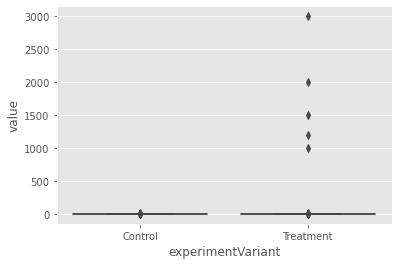

In [170]:
sns.boxplot(data=df, x='experimentVariant', y='value')

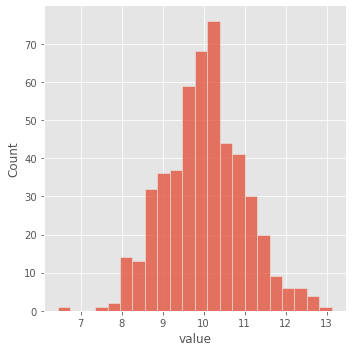

In [172]:
sns.displot(control)

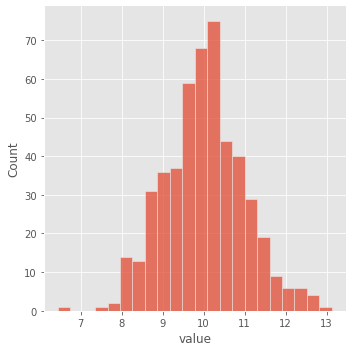

In [178]:
# как видно из боксплота в тестовой выборке есть (предположительно)выбросы - отфитруем их
sns.displot(test[test < 500])

# Задача 1.
Сравните результат между тестом и контролем по двум кейсам:
* Примените бутстрэп (с **np.mean**) и критерий **mann-whitney**, а потом сравните **p-value**
* Примените бутстрэп (с **np.median**) и критерий **mann-whitney**, а потом сравните **p-value**.

## Объявим функцию
подходящую функцию возьмем из ноутбука **lecture_2.2_bootstrap.ipynb** который использовался в <a href='https://lab.karpov.courses/learning/85/module/1061/lesson/9089/26685/118949/'>лекции</a>

In [88]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрэпа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    raw_statistic_value = statistic(data_column_1-data_column_2)

    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--',colors='gray')
    plt.vlines(raw_statistic_value,ymin=0,ymax=50,linestyle='-',colors='y')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value,
            "statistic":raw_statistic_value}

In [200]:
# общие строковые константы чтоб не дублировать
__can_reject_h0 = 'Есть основания для откланения нулевой гипотезы'
__cannot_reject_h0 = 'Не можем отклонить нулевую гипотезу'
__h0_mean = 'о равенстве средних в контрольной и тестовой группах'
__h0_median = 'о равенстве медиан в контрольной и тестовой группах'

In [194]:
# объявим функцию для получения сообщения на основе p-value
def get_conclusion_msg(p_value, alpha, h0):
    how =''
    conclusion = f'{__can_reject_h0} {h0}'
    sign = "<="
    if p_value > alpha:
        how = 'НЕ'
        conclusion = f'{__cannot_reject_h0} {h0}'
        sign = '>'
    
    return f'{round(p_value,6)}{sign}{alpha}\nСредние значения тестовой и контрольной групп отличаются {how}значимо\n{conclusion}'


In [196]:
# объявим функцию для получения сообщения на основе результата бутстрэпа
def get_conclusion_msg_by_bootstrap(low, high, statistic, statistic_name , h0):

    conclusion = f'{__cannot_reject_h0} {h0}'
    if low < 0 and 0 < high:
        conclusion = f'{__cannot_reject_h0} {h0}' 

    return f'''Результат бутстрэпа:
доверительный интервал: ({low} ; {high})
{statistic_name}: {statistic}
{conclusion}'''

Применим бутстрэп (с **np.mean**)

100%|██████████| 2000/2000 [00:00<00:00, 3194.64it/s]


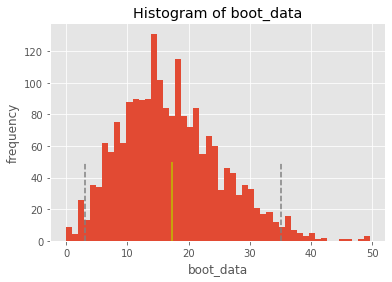

In [134]:
result_mean = get_bootstrap(
    data_column_1=test, 
    data_column_2=control,
    boot_it=2000,
    statistic=np.mean,
    bootstrap_conf_level = 0.95)


In [199]:
conclusion_pvalue = get_conclusion_msg(result_mean['p_value'], 0.05, __h0_mean)

conclusion_ci = get_conclusion_msg_by_bootstrap(
    low=result_mean['ci'].iloc[0][0],
    high=result_mean['ci'].iloc[1][0],
    statistic=result_mean['statistic'],
    statistic_name='среднее',
    h0=__h0_mean
)

print(f'{conclusion_pvalue}\n\n{conclusion_ci}')

0.036397<=0.05
Средние значения тестовой и контрольной групп отличаются значимо
Есть основания для откланения нулевой гипотезы о равенстве средних в контрольной и тестовой группах

Результат бутстрэпа:
доверительный интервал: (3.0899540128491947 ; 35.11936035307161)
среднее: 17.29463252285728
Не можем отклонить нулевую гипотезу о равенстве средних в контрольной и тестовой группах


Применим бутстрэп (с **np.median**)

100%|██████████| 2000/2000 [00:00<00:00, 2695.21it/s]


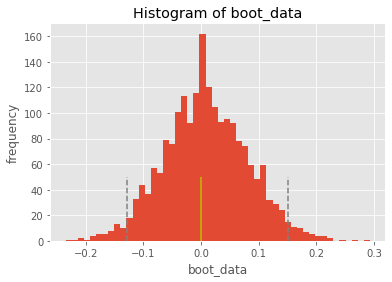

In [139]:
result_median = get_bootstrap(
    data_column_1=test, 
    data_column_2=control,
    boot_it=2000,
    statistic=np.median,
    bootstrap_conf_level = 0.95)

In [201]:
conclusion_pvalue = get_conclusion_msg(result_median['p_value'], 0.05, __h0_median)

conclusion_ci = get_conclusion_msg_by_bootstrap(
    low=result_median['ci'].iloc[0][0],
    high=result_median['ci'].iloc[1][0],
    statistic=result_median['statistic'],
    statistic_name='медиана',
    h0=__h0_median
)

print(f'{conclusion_pvalue}\n\n{conclusion_ci}')

0.907902>0.05
Средние значения тестовой и контрольной групп отличаются НЕзначимо
Не можем отклонить нулевую гипотезу о равенстве медиан в контрольной и тестовой группах

Результат бутстрэпа:
доверительный интервал: (-0.1290694017451122 ; 0.1508214372649216)
медиана: 0.0
Не можем отклонить нулевую гипотезу о равенстве медиан в контрольной и тестовой группах


Применим U-критерий Манна — Уитни (**mannwhitneyu**)

In [142]:
statistic, p_value = mannwhitneyu(
    x=test,
    y=control
)

In [202]:
conclusion = get_conclusion_msg(p_value, 0.05, __h0_mean)

print(f'''Результат U-критерия Манна — Уитни:
значение критерия: {statistic}
p-value: {p_value}

{conclusion}''')

Результат U-критерия Манна — Уитни:
значение критерия: 125810.5
p-value: 0.8592148582485579

0.859215>0.05
Средние значения тестовой и контрольной групп отличаются НЕзначимо
Не можем отклонить нулевую гипотезу о равенстве средних в контрольной и тестовой группах


# Задача 2. Выводы

1. бутстрэп для подсчета среднего (**np.mean**) показал что выборки значимо отличаются:
    * **p-value** (0.036397<=0.05)
    * а так же доверительный интервал (3.0899540128491947 ; 35.11936035307161) не включает 0
    
2.  бутстрэп для подсчета медианы (**np.median**) показал что выборки не отличаются:
    * **p-value** (0.907902>0.05)
    * а также доверительный интервал (-0.1290694017451122 ; 0.1508214372649216) включет 0

3. Использование U-критерия Манна—Уитни показало что выборки не отличаются:
    * **p-value** (0.859215>0.05), что согласуется со вторым способом бутстрэп от медианы

Получается что используя среднее как сравнительную статистику для оценки схожести имеющихся выборок привело бы к ошибке I рода, неверному отклонению нулевой гипотезы и принятии решения о значимом различии результатов.

Кроме того что бутсрэп от медианы в данном случае согласуется с U-критерием Манна-Уитни, результат бутсрэпа позваляет с большей уверенностью придерживаться версии о равенстве выборок (нулевой гипотезы) благодаря более высокому **p-value**